# Importing required libraries

In [20]:
import typing

import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

# Data


## Load the dataset

Dataset is downloaded from [Zenodo](https://zenodo.org/records/7816008). 
We use the `PEMS04.npz` file for PEMSD4, part of the PeMS (Performance Measurement System) datasets—collected by the California Department of Transportation (Caltrans)

PeMSD8 is collected from 307 sensors in the San Francisco Bay Area, from January 1, 2018 to February 28, 2018

In [21]:
pems_data = np.load("PEMS04.npz")   
pems_data = pems_data['data']
print(f"Shape of the data: {pems_data.shape}")

Shape of the data: (16992, 307, 3)


Feature | 	Description	Units 
- Speed:  Average speed of vehicles detected	mph or km/h
- Occupancy:  Proportion of time the detector is occupied by vehicles	percentage (0–100%)
- Flow:   Number of vehicles passing the detector during the interval	vehicles per 5 min

In [22]:
flow, occupancy, speed = pems_data[:,:,0], pems_data[:,:,1], pems_data[:,:,2]

In [23]:
sensor_df_all = [] # store all dfs of each sensor separately
for i in range(pems_data.shape[1]):
    df = pd.DataFrame({
        "time_step": np.arange(pems_data.shape[0]),
        "sid": i,
        "speed": speed[:,i],
        "occupancy": occupancy[:,i],
        "flow": flow[:, i]
    })
    sensor_df_all.append(df)

In [24]:
# Choose 1 particular sensor
data = sensor_df_all[0]

<Axes: xlabel='speed', ylabel='Count'>

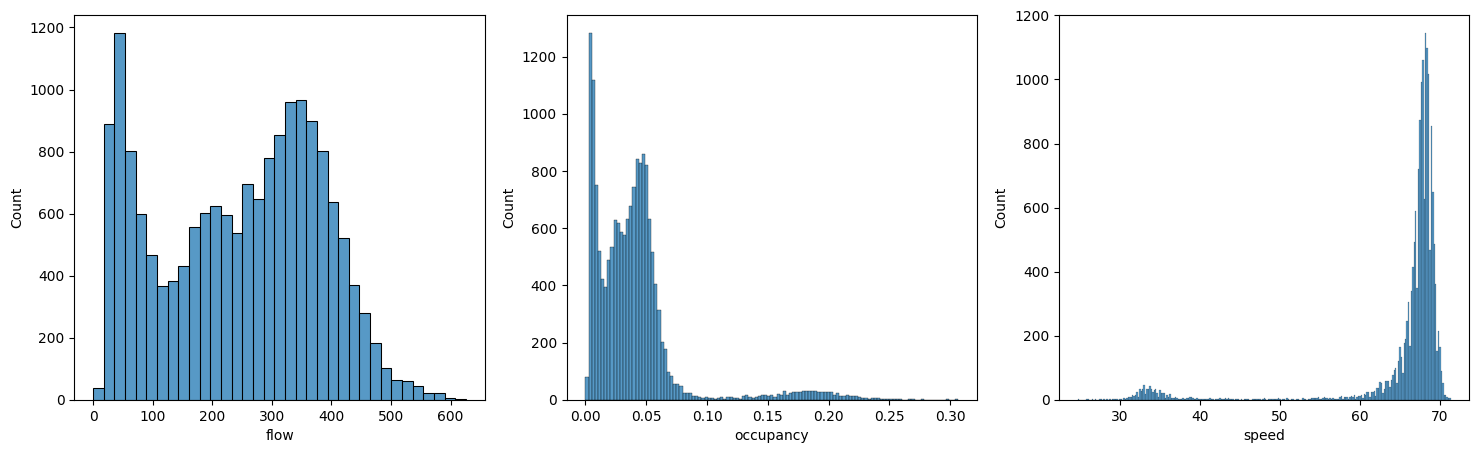

In [25]:
_, ax0 = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(data,x= "flow", ax=ax0[0])
sns.histplot(data,x= "occupancy", ax=ax0[1])
sns.histplot(data,x= "speed", ax=ax0[2])


## Dataframe Manipulation

We want to group data by hour to reduce number of data points and smoothen the data.

In [26]:
data["dt_mins"] = pd.to_timedelta(data['time_step']*5, unit = "m")
data["hour"] = (data["dt_mins"].dt.total_seconds() // 3600).astype(int)

In [27]:
data_hourly = data.groupby(["sid", "hour"], as_index= False)[['flow', 'occupancy', 'speed']].mean()

In [28]:
data_hourly.head()

,sid,hour,flow,occupancy,speed
0,0,0,113.083333,0.015033,67.008333
1,0,1,126.333333,0.018300,65.900000
2,0,2,90.583333,0.012158,66.033333
3,0,3,67.916667,0.008725,67.516667
4,0,4,54.500000,0.007133,66.708333


## Preprocessing

We check for null values and then standardize all features, to have clean and uniformly scaled data.

In [29]:
np.sum(data_hourly.isna().sum() > 0) # check for null values

np.int64(0)

In [30]:
X = data_hourly.drop(columns=["sid", "hour"]).to_numpy() # remove sensor id
X = (X - X.mean(axis=0)) / X.std(axis=0) # standardization

# GMM

We implement the Gaussian Mixture Model using `numpy` and `scipy`.

To get better initial conditions we keep `KMeans from scikit-learn`, as optional.

In [31]:
def gmm(X: np.ndarray, max_iter: int, n_clusters: int, init_method: typing.Literal["kmeans", "random"] = "random", seed: int = 42):
    n, d = X.shape
    k = n_clusters
    prev_ll = -np.inf # initialize likelihood
    tol = 1e-6
    lls = []
    c_pi = np.ones(k) / k # mixing coeffs
    c_sigma = np.array([np.eye(d) for _ in range(k)]) # cluster cov initialized as identity matrices
    if init_method == 'kmeans':
        km = KMeans(n_clusters=k, random_state=seed, n_init=2).fit(X)
        c_mu = km.cluster_centers_.astype(float) # cluster means initialize from K Means cluster centers
    else:
        np.random.seed(seed)
        init_idx = np.random.choice(len(X), k, replace=False)
        c_mu = X[init_idx] # cluster means initialize from random datapoints
    for iter in range(max_iter):
        resp = np.zeros((n, k))
        log_resp = np.zeros((n,k))
        for j in range(k):
            gaussian = multivariate_normal(mean=c_mu[j], cov=c_sigma[j], allow_singular=True) # Normal Function
            log_resp[:, j] = np.log(c_pi[j]) + gaussian.logpdf(X) 
        log_resp_norm = logsumexp(log_resp, axis=1, keepdims=True) # take log of summation of exp of the logprobs for every point
        resp = np.exp(log_resp - log_resp_norm)  
        N_k = resp.sum(axis=0)  # total cluster responsibility for all points
        c_mu = np.einsum('nk,nd->kd', resp, X) / N_k[:, None] # update cluster mean
        c_sigma = np.zeros((k, d, d))
        for j in range(k):
            xdiff = X - c_mu[j]
            c_sigma[j] = np.einsum('n,ni,nj->ij', resp[:, j], xdiff, xdiff) / N_k[j] # update cluster cov
            c_sigma[j] += np.eye(d) * 1e-6
        c_pi = N_k / n # update mixing coefficients
        curr_log_likelihood = log_resp_norm.sum()
        lls.append(curr_log_likelihood)
        if np.abs(curr_log_likelihood - prev_ll) < tol: # check if not sufficient improvement in curr iter
            print(f"Termination criteria reached")
            break
        prev_ll = curr_log_likelihood
    return c_pi, c_mu, c_sigma, resp, lls


# Calculation

The shape of out dataset is:

In [32]:
print(f"Number of points:   {X.shape[0]}\nNumber of features:  {X.shape[1]}")

Number of points:   1416
Number of features:  3


In [33]:
mix, mu, sigma, resp, ll = gmm(X, max_iter=200, n_clusters=2, init_method="kmeans", seed= 42)
labels = np.argmax(resp, axis=1)

Termination criteria reached


# Results

In [34]:
print(f"Cluster assignment as # of points:\n{pd.Series(labels).value_counts(ascending = True)}")

print(f"\nMixing coefficients:\n{'  |   '.join([f'Cluster {i} -> {round(mix[i],3)}' for i in range(len(mix))])}")


Cluster assignment as # of points:
0     158
1    1258
Name: count, dtype: int64

Mixing coefficients:
Cluster 0 -> 0.114  |   Cluster 1 -> 0.886


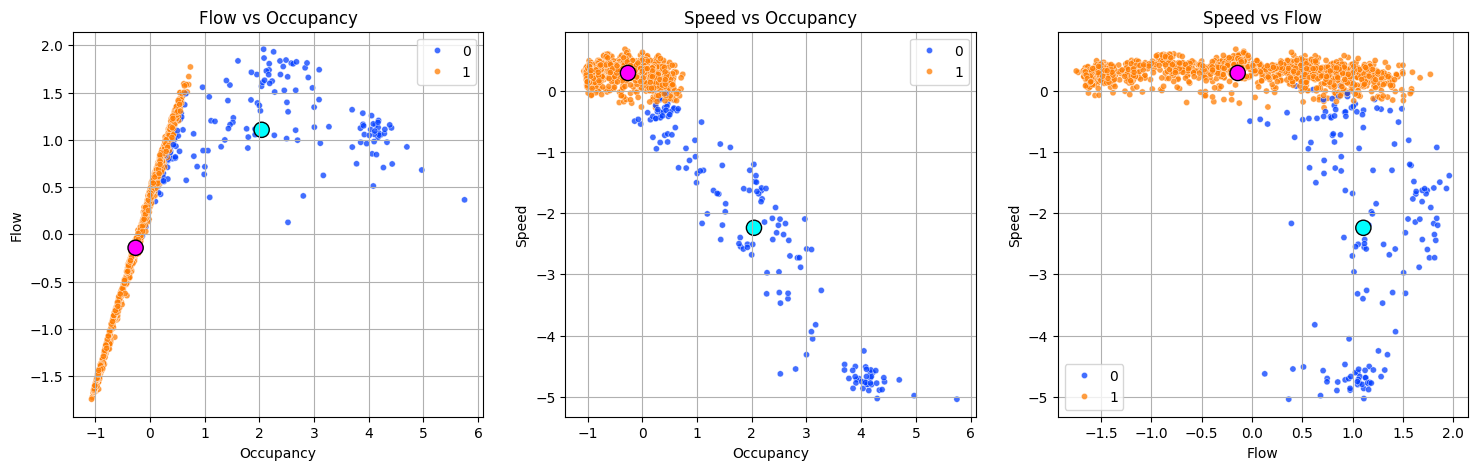

In [35]:
_, ax1 = plt.subplots(1, 3, figsize=(18, 5))
colors = ["cyan", "magenta","yellow"][:2]
sns.scatterplot(data = pd.DataFrame(X), x= 1, y =0, hue = labels, palette="bright", s= 20, alpha=0.75, ax = ax1[0])
ax1[0].scatter(mu[:,1], mu[:,0], color=colors, s=120, edgecolor='k', marker="o", label="Cluster Means")
ax1[0].set_xlabel("Occupancy")
ax1[0].set_ylabel("Flow")
ax1[0].set_title("Flow vs Occupancy")
ax1[0].grid(True)


sns.scatterplot(data = pd.DataFrame(X), x= 1, y =2, hue = labels, palette="bright", s= 20, alpha=0.75, ax = ax1[1])
ax1[1].scatter(mu[:,1], mu[:,2], color=colors, s=120, edgecolor='k', marker="o", label="Cluster Means")
ax1[1].set_xlabel("Occupancy")
ax1[1].set_ylabel("Speed")
ax1[1].set_title("Speed vs Occupancy")
ax1[1].grid(True)


sns.scatterplot(data = pd.DataFrame(X), x= 0, y =2, hue = labels, palette="bright", s= 20, alpha=0.75, ax = ax1[2])
ax1[2].scatter(mu[:,0], mu[:,2], color=colors, s=120, edgecolor='k', marker="o", label="Cluster Means")
ax1[2].set_xlabel("Flow")
ax1[2].set_ylabel("Speed")
ax1[2].set_title("Speed vs Flow")
ax1[2].grid(True)



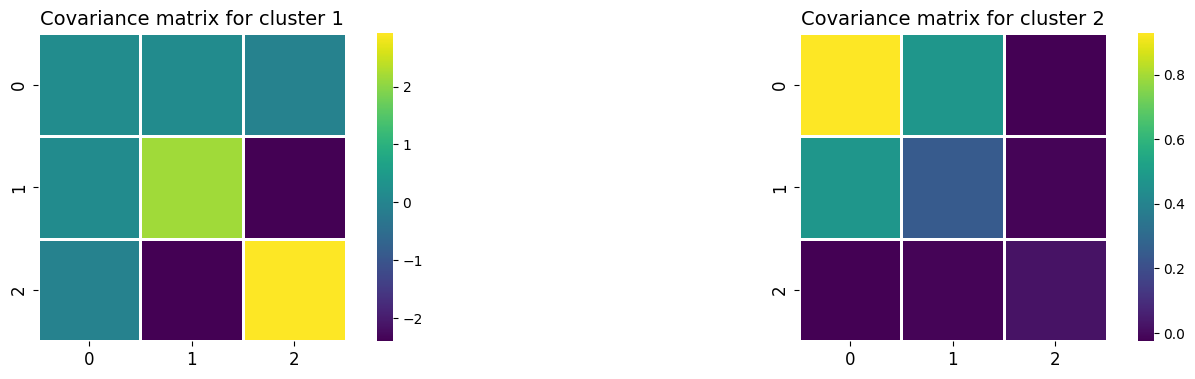

In [36]:
_, ax2 = plt.subplots(1, sigma.shape[0], figsize=(18, 4))

for i in range(sigma.shape[0]):
    sns.heatmap(sigma[i,:,:], ax = ax2[i], cmap="viridis", square=True, linewidth=2)
    ax2[i].set_title(f"Covariance matrix for cluster {i+1}", fontsize= 14)
    ax2[i].tick_params(axis='both', which='major', labelsize=12)
